In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
def up_dim(image):
	if len(image.shape) == 2:
		h, w = image.shape
		new_image = np.zeros((h, w, 3), dtype=image.dtype)
		new_image[:, :, 0] = image
		return new_image
	return np.copy(image)

In [3]:
#đọc ảnh
def read_image(path):

	if isinstance(path, list):
		return [read_image(mem) for mem in path]
	
	img = cv2.imread(path) 
	img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
	return img

#in ảnh
def show_row(images, cmap='gray', figsize=(12,4)):

    n = len(images)
    plt.figure(figsize=figsize)

    for i, img in enumerate(images):
        plt.subplot(1, n, i+1)
        if cmap and (img.ndim == 2 or (img.ndim == 3 and img.shape[2] == 1)):
            plt.imshow(img, cmap=cmap)
        else:
            plt.imshow(img)
        plt.axis("off")

    plt.show()



#in biểu đề histogram
def show_histograms_row(images, figsize=(15, 4)):
    n = len(images)
    plt.figure(figsize=figsize)

    for i, img in enumerate(images):
        plt.subplot(1, n, i+1)

        # Ảnh xám
        if img.ndim == 2 or (img.ndim == 3 and img.shape[2] == 1):
            plt.hist(img.ravel(), bins=256, color='black', alpha=0.8)
            plt.xlim([0, 255])

        # Ảnh màu (RGB)
        elif img.ndim == 3 and img.shape[2] == 3:
            for j, col in enumerate(['r', 'g', 'b']):
                plt.hist(img[:, :, j].ravel(), bins=256, color=col, alpha=0.5)
            plt.xlim([0, 255])

        plt.axis("on") 
        plt.xlabel("")
        plt.ylabel("")
        plt.title("")

    plt.tight_layout()
    plt.show()


In [4]:
# biến thành ảnh trắng đen
def to_grayscale(image):

	if isinstance(image, list):
		return [to_grayscale(img) for img in image]

	if image.ndim == 2:
		return np.copy(image)
	
	h, w, ndim = image.shape

	for x in range(h):
		for y in range(w):
			image[x, y, 0] = np.sum(image[x, y]) // 3

	return np.copy(image[:,:,0])

In [5]:
#nhị phân hóa một ảnh
def binarize_img(image, thres = 127):

	if isinstance(image, list):
		return [binarize_img(mem, thres) for mem in image]

	img_cpy = to_grayscale(image)

	h, w = img_cpy.shape

	for x in range(h):
		for y in range(w):
			img_cpy[x, y] = 255 if img_cpy[x, y] >= thres else 0

	return img_cpy

In [6]:
# Cân bằng histogram
def apply_histogram_equalization(img):

	if isinstance(img, list):
		return [apply_histogram_equalization(mem) for mem in img]

	def cal_pdf(img):
		hist = np.bincount(img.flatten(), minlength=256)
		pdf = hist / float(img.size)
		return pdf

	def cal_cdf(pdf):
		return np.cumsum(pdf)

	pdf = cal_pdf(img)
	cdf = cal_cdf(pdf)
	L = 256
	transform_map = np.round((L - 1) * cdf).astype(np.uint8)
	return transform_map[img]

In [7]:
# CLAHE
def clahe_manual(img, tile_size=16, clip_limit_ratio=0.008):
		
	if isinstance(img, list):
		return [clahe_manual(mem, tile_size, clip_limit_ratio) for mem in img]
	
	if img.ndim == 3:
		return np.stack([clahe_manual(img[:, :, c], tile_size, clip_limit_ratio) for c in range(img.shape[2])], axis=2)

	h, w = img.shape
	L = 256

	n_tiles_y = (h + tile_size - 1) // tile_size
	n_tiles_x = (w + tile_size - 1) // tile_size

	pad_h = n_tiles_y * tile_size - h
	pad_w = n_tiles_x * tile_size - w
	img_padded = cv2.copyMakeBorder(img, 0, pad_h, 0, pad_w, cv2.BORDER_REFLECT)

	h_pad, w_pad = img_padded.shape
	result = np.zeros_like(img_padded)
	lut_tiles = np.zeros((n_tiles_y, n_tiles_x, L), dtype=np.uint8)

	# Tính LUT cho từng tile
	for i in range(n_tiles_y):
		for j in range(n_tiles_x):
			y0, y1 = i * tile_size, (i + 1) * tile_size
			x0, x1 = j * tile_size, (j + 1) * tile_size
			tile = img_padded[y0:y1, x0:x1]

			hist = np.bincount(tile.flatten(), minlength=L)

			clip_limit = max(int(clip_limit_ratio * tile.size), 1)
			excess = np.maximum(hist - clip_limit, 0)
			total_excess = np.sum(excess)
			hist = np.minimum(hist, clip_limit)

			hist += total_excess // L
			hist[:total_excess % L] += 1

			# CDF chuẩn hóa
			cdf = np.cumsum(hist).astype(np.float32)
			cdf = (cdf - cdf[0]) / (cdf[-1] - cdf[0] + 1e-6)

			lut = np.round(cdf * (L - 1)).astype(np.uint8)
			lut_tiles[i, j] = lut

	# Áp dụng nội suy bilinear giữa các tile
	for i in range(h_pad):
		for j in range(w_pad):
			ty, tx = i // tile_size, j // tile_size
			dy, dx = (i % tile_size) / tile_size, (j % tile_size) / tile_size

			ty1 = min(ty + 1, n_tiles_y - 1)
			tx1 = min(tx + 1, n_tiles_x - 1)

			val = img_padded[i, j]
			tl = lut_tiles[ty,  tx,  val]
			tr = lut_tiles[ty,  tx1, val]
			bl = lut_tiles[ty1, tx,  val]
			br = lut_tiles[ty1, tx1, val]

			top = (1 - dx) * tl + dx * tr
			bottom = (1 - dx) * bl + dx * br
			interpolated = (1 - dy) * top + dy * bottom

			result[i, j] = int(np.round(interpolated))

	return result[:h, :w]

In [8]:
# kéo dải tương phản
def stretch_contrast(img, r1, r2, s1, s2):
		
	if isinstance(img, list):
		return [stretch_contrast(mem, r1, r2, s1, s2) for mem in img]
	
	out = img.astype(np.float32)

	mask1 = img <= r1
	out[mask1] = (s1 / r1) * img[mask1]

	mask2 = (img > r1) & (img <= r2)
	out[mask2] = ((s2 - s1) / (r2 - r1)) * (img[mask2] - r1) + s1

	mask3 = img > r2
	out[mask3] = ((255 - s2) / (255 - r2)) * (img[mask3] - r2) + s2

	return np.clip(out, 0, 255).astype(np.uint8)


In [9]:
# ảnh âm bản
def negative_image(image):
	if isinstance(image, list):
		return [negative_image(img) for img in image]
	
	return 255 - image

In [10]:
# paths = glob.glob('../images/*.jpg') + glob.glob('../images/*.png') + glob.glob('../images/*.jpeg')
# print(paths)

## Ví Dụ Biển Số 1

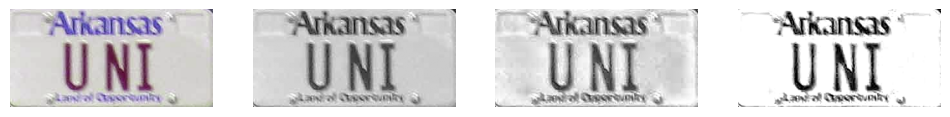

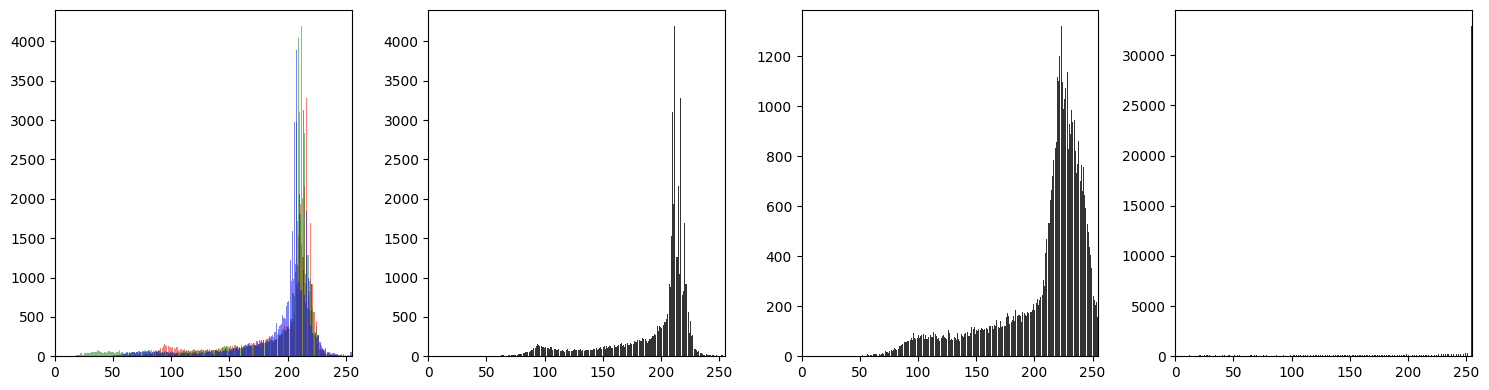

In [11]:
paths = glob.glob('../images/bien3.png')

pipeline = []
pipeline.append(read_image(paths[0]))
pipeline.append(to_grayscale(pipeline[-1]))
pipeline.append(clahe_manual(pipeline[-1]))
pipeline.append(stretch_contrast(pipeline[-1], 90, 210, 0, 255))

show_row(pipeline)
show_histograms_row(pipeline)

## Ví Dụ Biển Số 2

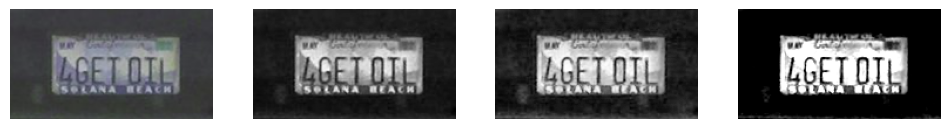

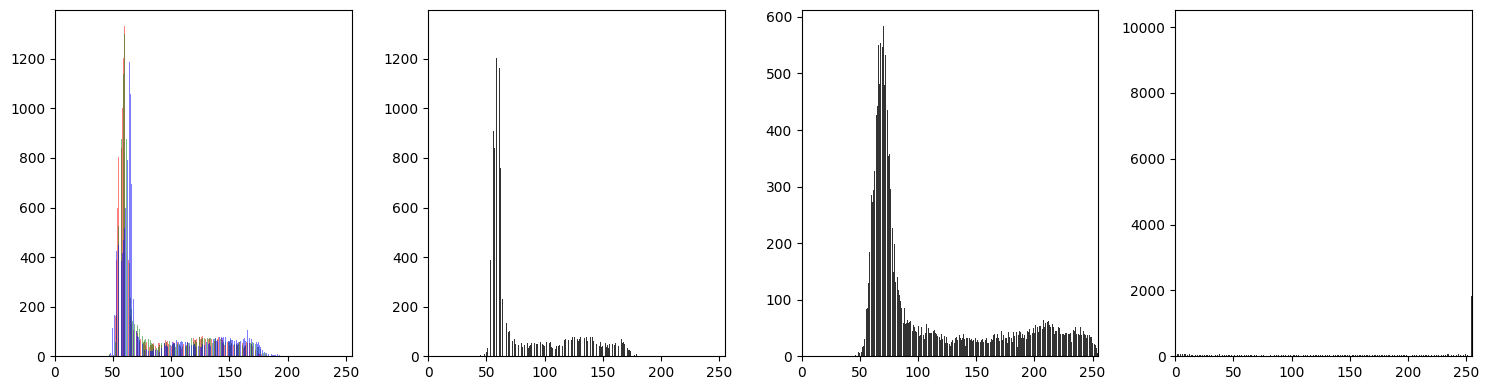

In [12]:
paths = glob.glob('../images/bien2.png')

pipeline = []
pipeline.append(read_image(paths[0]))
pipeline.append(to_grayscale(pipeline[-1]))
pipeline.append(clahe_manual(pipeline[-1]))
pipeline.append(stretch_contrast(pipeline[-1], 90, 210, 0, 255))

show_row(pipeline)
show_histograms_row(pipeline)

## Ví Dụ Biển Số 3

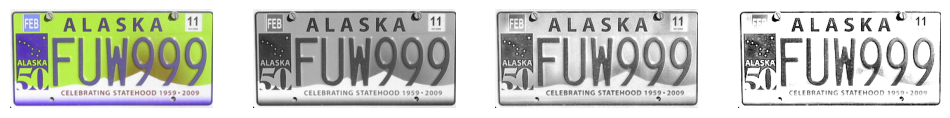

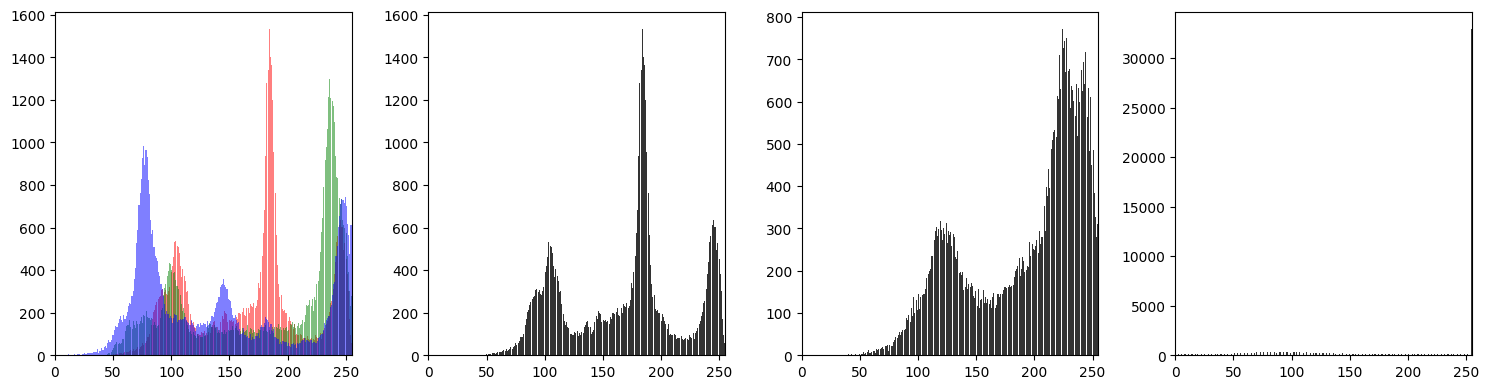

In [13]:
paths = glob.glob('../images/bien1.png')

pipeline = []
pipeline.append(read_image(paths[0]))
pipeline.append(to_grayscale(pipeline[-1]))
pipeline.append(clahe_manual(pipeline[-1]))
pipeline.append(stretch_contrast(pipeline[-1], 90, 180, 0, 255))

show_row(pipeline)
show_histograms_row(pipeline)

## Ví Dụ Khôi Phục Tài Liệu

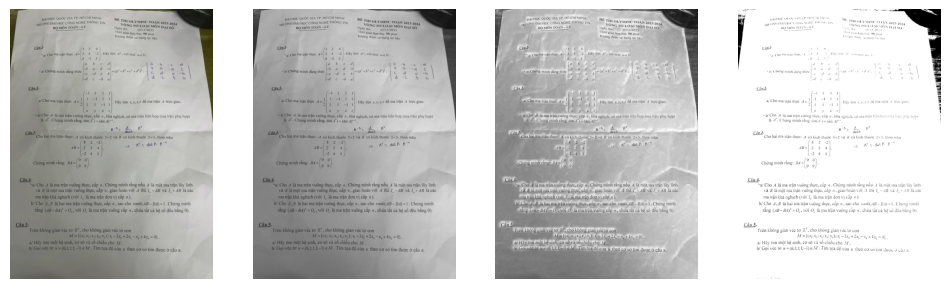

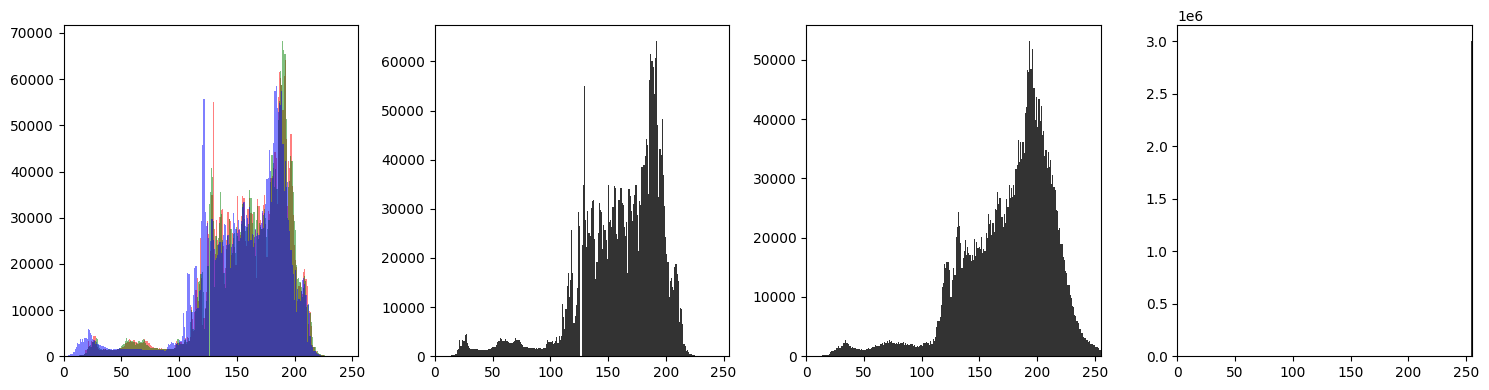

In [14]:
paths = glob.glob('../images/tailieu.jpg')

pipeline = []
pipeline.append(read_image(paths[0]))
pipeline.append(to_grayscale(pipeline[-1]))
pipeline.append(clahe_manual(pipeline[-1]))
pipeline.append(stretch_contrast(pipeline[-1], 80, 100, 0, 255))

show_row(pipeline)
show_histograms_row(pipeline)

## Ví dụ Khôi Phục Hóa Đơn

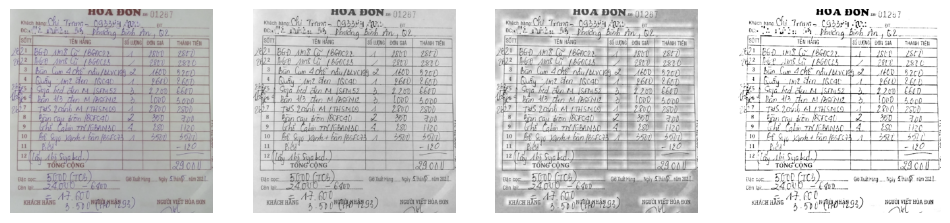

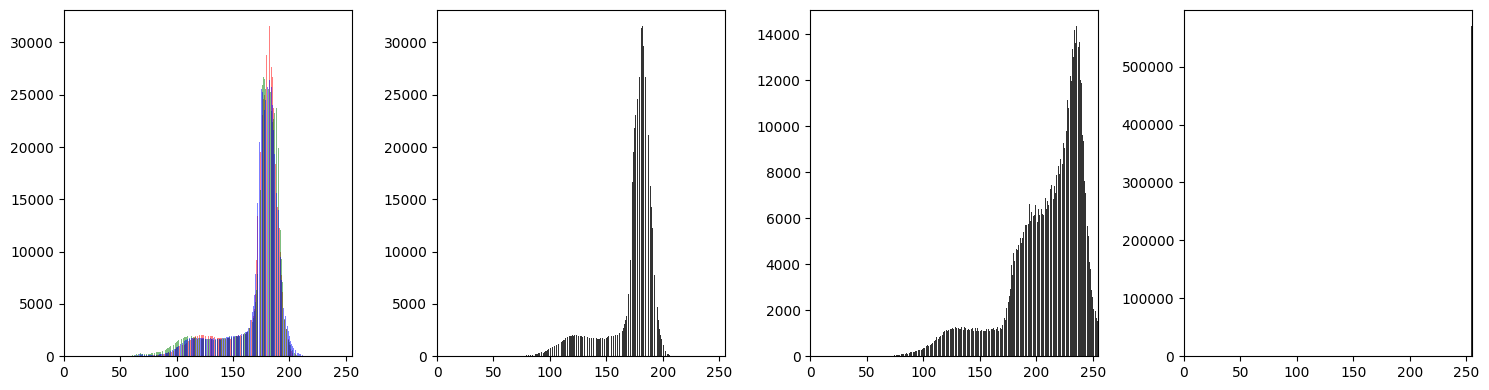

In [15]:
paths = glob.glob('../images/hoadon.jpg')

pipeline = []
pipeline.append(read_image(paths[0]))
pipeline.append(to_grayscale(pipeline[-1]))
pipeline.append(clahe_manual(pipeline[-1]))
pipeline.append(stretch_contrast(pipeline[-1], 140, 170, 0, 255))

show_row(pipeline)
show_histograms_row(pipeline)

## Ví Dụ Hỗ Trợ Nhận Diện Trong Y Tế

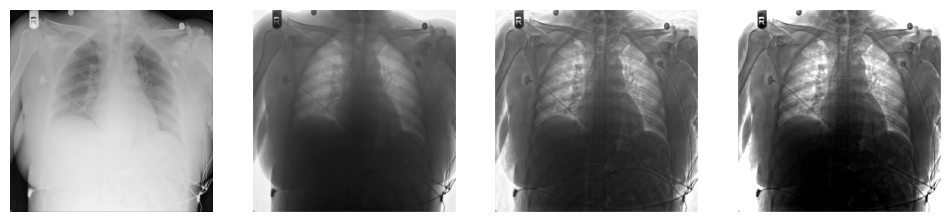

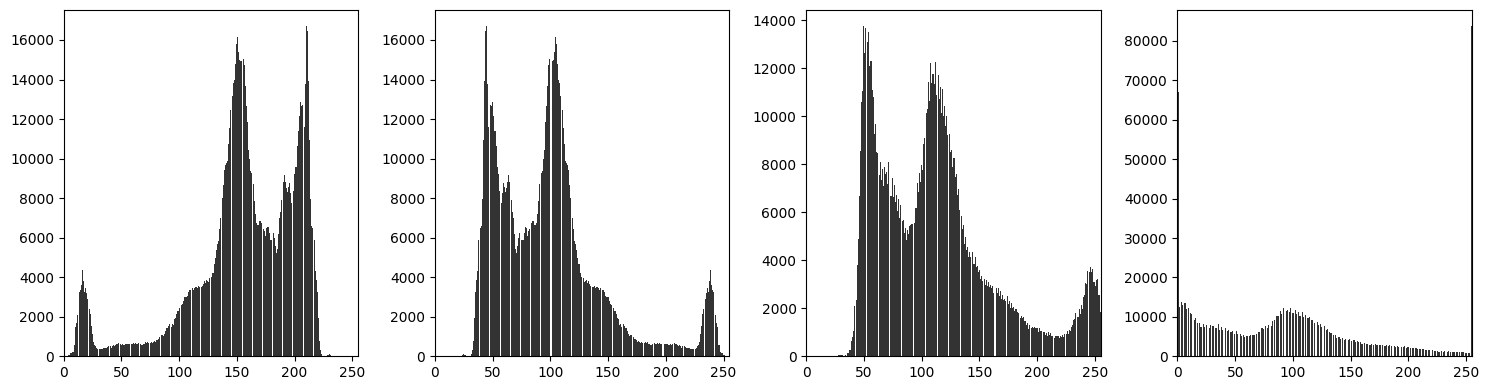

In [16]:
paths = glob.glob('../images/yte.png')

pipeline = []
pipeline.append(to_grayscale(read_image(paths[0])))
pipeline.append(negative_image(pipeline[-1]))
pipeline.append(clahe_manual(pipeline[-1]))
pipeline.append(stretch_contrast(pipeline[-1], 50, 210, 0, 255))

show_row(pipeline)
show_histograms_row(pipeline)